# Step 3: Intial step to convert data into vectors, observing distance matrics and cllustering algorithmn

In [1]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
# libraries for preprocessing
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.util import ngrams

import string
#libraries for similarity matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity

# for word cloud
import csv
from wordcloud import WordCloud

# libraries for agglomerative clustering
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram


In [55]:
# load data
df = pd.read_csv('finalnouns.csv', index_col=0)

In [3]:
# observing noun column
df.Nounss

id
KQe1r321ZaJY    ['Færre', 'klimakrisen', 'tiltak', 'koronapand...
jnegLMrLkawZ                  ['Oslo-Fergenes', 'dag', 'fjorden']
Jrb2vD34MbWL                     ['raid', 'bankrøvere', 'Brasil']
xkazKYRPqbJ0                                   ['Sandra', 'Lyng']
Vyb86KpPrevA     ['Aborttilgangen', 'Texas-loven', 'Høyesterett']
                                      ...                        
LDdwmx6pXa1Y               ['Strømstans', 'Båtsfjord', 'kommune']
J0dN9G6R2bLO                                      ['Odd', 'hest']
K9b6RMAP7bEv               ['Strømstans', 'Båtsfjord', 'kommune']
YQdJq19p2bOG    ['Statusoppdatering', '13.11.21', 'LOABÁGA', '...
APdRoXvwqeGy    ['Norges', 'onlinelag', 'Lichess', 'mandag', '...
Name: Nounss, Length: 87638, dtype: object

In [4]:
df.shape

(87638, 33)

## preprocessing

In [5]:
#initialize tokenizer and stemmer
tokenizer = RegexpTokenizer('[^\W\d_]+') 
stemmer = SnowballStemmer("norwegian", ignore_stopwords=True)

def clean(doc):   
    doc_ = doc

    # make all lower case
    doc_ = doc_.lower()
    
    # tokenize text. regex includes alphabetic characters, including letters with accents. 
    # excludes punctuation and numbers.
    words = tokenizer.tokenize(doc_)
    
    
    # stemming
    stems = list(map(stemmer.stem, words))

    doc_ = " ".join(stems)
    
    # count number of words 
    n_words = len(words)

    return doc_#, title_words, n_words

In [6]:
# clean nouns
df.nouns_clean = df.Nounss.apply(clean)

# convert nouns to list of strings
nouns_words = df.nouns_clean.apply(lambda x: x.split(' '))

<ipython-input-6-7afe24557220>:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.nouns_clean = df.Nounss.apply(clean)


In [7]:
df.nouns_clean

id
KQe1r321ZaJY                  færr klimakris tiltak koronapandemi
jnegLMrLkawZ                                  oslo ferg dag fjord
Jrb2vD34MbWL                                raid bankrøver brasil
xkazKYRPqbJ0                                           sandr lyng
Vyb86KpPrevA                     aborttilgang tex lov høyesterett
                                      ...                        
LDdwmx6pXa1Y                           strømstan båtsfjord kommun
J0dN9G6R2bLO                                             odd hest
K9b6RMAP7bEv                           strømstan båtsfjord kommun
YQdJq19p2bOG                     statusoppdatering loabág suohkan
APdRoXvwqeGy    norg onlinelag lichess mandag kl tromsø sjakklubb
Name: Nounss, Length: 87638, dtype: object

In [8]:
# write norwegian stopwords to file
file2write=open("/Users/nimrarana/Downloads/norwegian_stopwords.txt",'w')
file2write.write('\n'.join(stopwords.words('norwegian')))
file2write.close()

# read stopwords from file
sw = [line.strip("\n") for line in open("/Users/nimrarana/Downloads/norwegian_stopwords.txt", "r")]

In [56]:
# observing how tokenizer works
totoke = df.Nounss.values[3]
print('Original title : ' + totoke)
print(tokenizer.tokenize(totoke))
print(list(map(stemmer.stem, tokenizer.tokenize(totoke))))

totoke = df.Nounss.values[1]
print('Original title : ' + totoke)
print(tokenizer.tokenize(totoke))
print(list(map(stemmer.stem, tokenizer.tokenize(totoke))))

Original title : ['Sandra', 'Lyng']
['Sandra', 'Lyng']
['sandr', 'lyng']
Original title : ['Oslo-Fergenes', 'dag', 'fjorden']
['Oslo', 'Fergenes', 'dag', 'fjorden']
['oslo', 'ferg', 'dag', 'fjord']


In [57]:
# create n-grams
print(list(ngrams(nouns_words[1], 2)))

[('oslo', 'ferg'), ('ferg', 'dag'), ('dag', 'fjord')]


In [11]:
# initialize vectorizer to count words
vectorizer = CountVectorizer(stop_words=sw)

# fit vectorizer to corpus of nouns
vectorizer.fit(df.nouns_clean)

# Looking at a small sample of the vocabulary:
vocabulary = list(vectorizer.vocabulary_.keys())
print("Small sample of the vocabulary:", vocabulary[0:20])

# Number of words in the vocabulary
print("\nNumber of distinct words:", len(vocabulary))

# convert data to word counts
word_count_matrix = vectorizer.transform(df.nouns_clean.values)

print('Word count vectorization has %d entries and %d words' % word_count_matrix.shape)

Small sample of the vocabulary: ['færr', 'klimakris', 'tiltak', 'koronapandemi', 'oslo', 'ferg', 'dag', 'fjord', 'raid', 'bankrøver', 'brasil', 'sandr', 'lyng', 'aborttilgang', 'tex', 'lov', 'høyesterett', 'brannfolk', 'øving', 'vilj']

Number of distinct words: 37317
Word count vectorization has 87638 entries and 37317 words


In [12]:
# get total word count per word
word_count = np.squeeze(np.asarray(word_count_matrix.sum(axis=0)))

wc_df = pd.Series(word_count, index=vectorizer.get_feature_names())



/Users/nimrarana/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [13]:
# get total word count per word
word_count = np.squeeze(np.asarray(word_count_matrix.sum(axis=0)))

wc_df = pd.Series(word_count, index=vectorizer.get_feature_names())

#wc_df.to_csv('nouns_word_count.csv')

In [15]:
#making word cloud
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

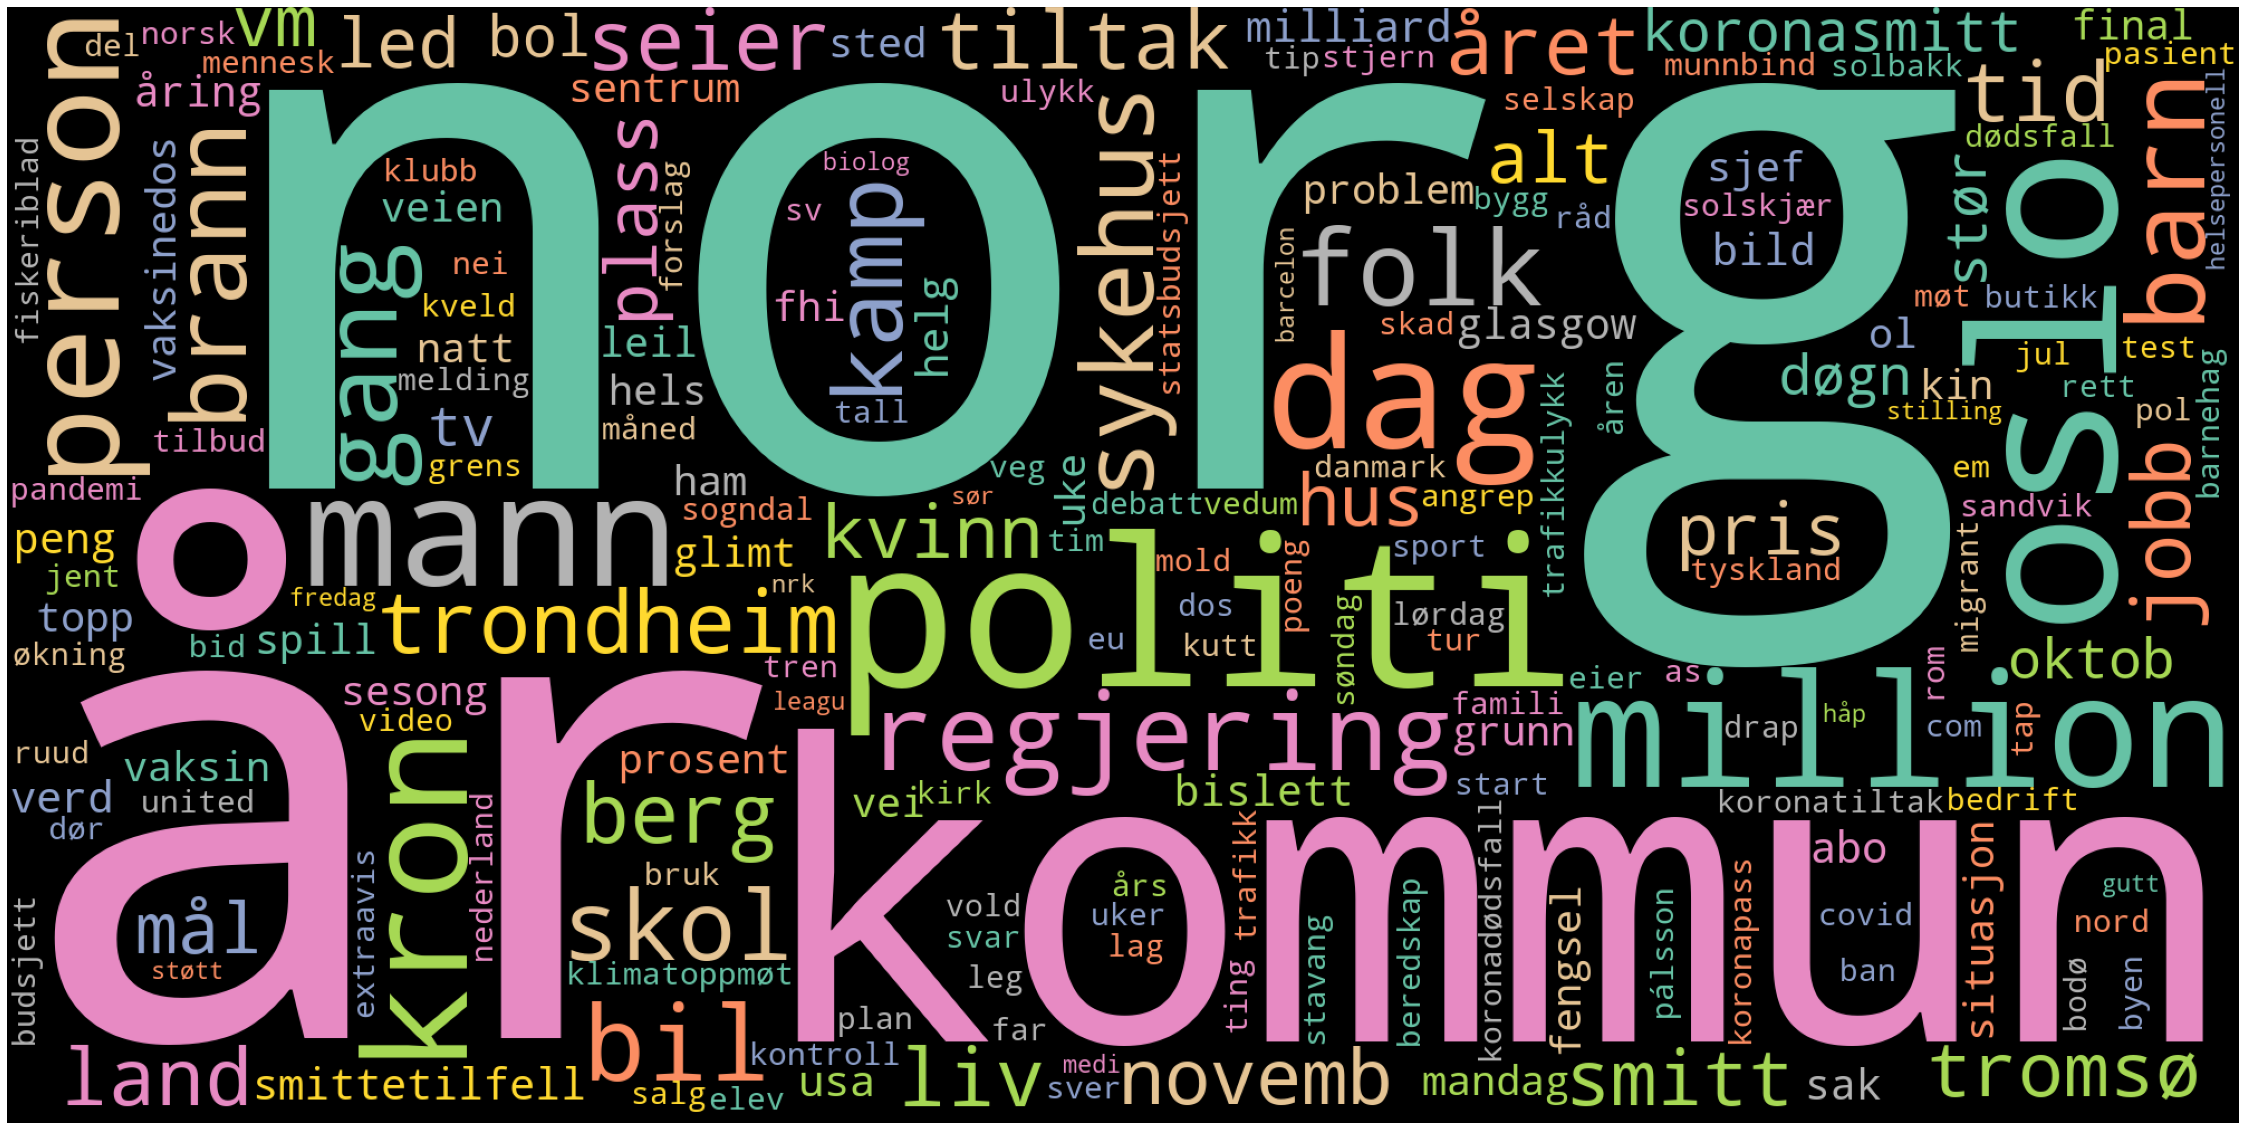

In [16]:
#generating word cloud
reader = csv.reader(open('nouns_word_count.csv', 'r',newline='\n'))
d = {}
for k,v in reader:
    d[k] = int(v)

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', colormap='Set2', collocations=False,).generate_from_frequencies(d)
# Plot
plot_cloud(wordcloud)

## Vectorization

In [17]:
# initialize TF-IDF counter
tfidf = TfidfTransformer()

# fit and transform to titles corpus
word_term_frequency_matrix = tfidf.fit_transform(word_count_matrix)

word_term_frequency_matrix

<87638x37317 sparse matrix of type '<class 'numpy.float64'>'
	with 287478 stored elements in Compressed Sparse Row format>

## Similarity matrix - cosine similarity

In [21]:
# create dataframe from TF-IDF values (only first 1000 articles)
tf = pd.DataFrame(word_term_frequency_matrix[:1000,:].toarray())

# calculate cosine similarity for each article
cs = cosine_similarity(tf)

In [22]:
# finding other similar articles
np.where(cs[12,:]>0)[0]

array([ 12,  13,  47,  54,  55,  73, 121, 154, 183, 184, 201, 204, 212,
       224, 930])

In [24]:
#observing how how cosine similarity works with tf-idfs
print('Original nouns in a title: %s' % df.iloc[47]['Nounss'])
for ind in np.where(cs[47,:]>0.2)[0]:
    print('%.2f : %s' % (cs[47,ind], df.iloc[ind]['Nounss']))

Original nouns in a title: ['brannar', 'Drammen']
0.48 : ['tenåringsjente', 'Drammen']
0.48 : ['tenåringsjente', 'Drammen']
1.00 : ['brannar', 'Drammen']
0.61 : ['brannar', 'Drammen', 'politiet', 'dei', 'påsette']
0.78 : ['Fleire', 'brannar', 'Drammen', 'dei']
0.66 : ['branner', 'Drammen', 'Lier', 'politiet']
0.31 : ['Vålerenga', 'Brann', '1-0', 'seier']
0.85 : ['brannar', 'tid', 'Drammen']
0.44 : ['branner', 'politiet']
0.23 : ['brann', 'angrep', 'Det', 'fakultet']
0.88 : ['branner', 'Drammen', 'politiet']
0.21 : ['VIF', 'Brann', 'streken', 'kroppen']
0.57 : ['Fleire', 'påsette', 'brannar', 'Drammen']
1.00 : ['branner', 'Drammen']
0.20 : ['mannen', 'Vålerenga', 'lysglimt', 'Brann-kveld']
0.20 : ['mannen', 'Vålerenga', 'lysglimt', 'Brann-kveld']
0.20 : ['mannen', 'Vålerenga', 'lysglimt', 'Brann-kveld']
0.88 : ['branner', 'Drammen', 'politiet']
0.88 : ['branner', 'Drammen', 'politiet']
0.88 : ['branner', 'Drammen', 'politiet']
0.80 : ['Drammen']
0.39 : ['Brann', 'vei']
0.22 : ['Brann', 

<AxesSubplot:>

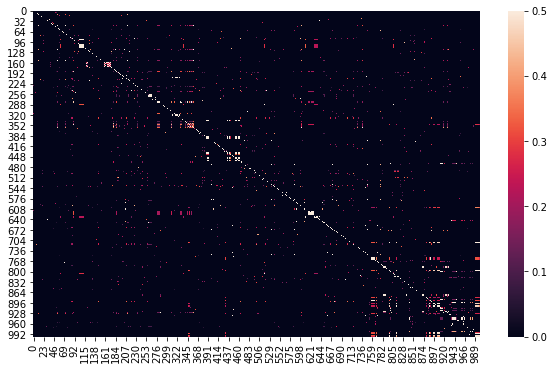

In [25]:
#generating corelation grapg to see how datapoints are correlated based on cosine similarity
f, ax = plt.subplots(figsize=(10,6))
sns.heatmap(cs, vmax = 0.5)

In [26]:
np.where(cs[760,:]>0.1)

(array([ 98, 431, 605, 681, 712, 758, 759, 760, 761, 763, 764, 765, 766,
        769, 798, 814, 874, 881, 888, 890, 897, 899, 901, 903, 905, 906,
        907, 908, 910, 930, 968, 988, 991, 992, 993, 995, 996, 997, 998,
        999]),)

In [27]:
df['cs'] = np.nan
df.iloc[:1000,-1] = cs[760,:]

In [28]:
# find similar articles
print('Original title: %s' % df.iloc[760]['Nounss'])
for idx, row in df.iloc[np.where(cs[760,:]>0.1)[0]][['title', 'Nounss', 'cs', 'domain']].iterrows():
    print(row.cs)
    print(row.title)
    print(row.Nounss)
    print(row.domain)
    print('---')

Original title: ['Molde', 'Strømsgodset']
0.2726904712896564
Molde avslo den viktige spillerens overgang til utenlandsk klubb
['Molde', 'spillerens', 'overgang', 'klubb']
sportsbibelen.no
---
0.3015613885280872
(+) Aloha from Molde
['Aloha', 'Molde']
www.rbnett.no
---
0.19867397688011973
(+)Flau Moe etter Moldes verste tap på 15 år: – Kan ikke løpe fra ansvaret mitt
['Flau', 'Moe', 'Moldes', 'tap', 'år', 'ansvaret']
www.rbnett.no
---
0.3015613885280872
(+) Molde fikk grisebank: – Vi er flaue
['Molde', 'grisebank']
www.tk.no
---
0.32022931594195553
Molde i full oppløsning i 6–0-tap: – Vi er skrekkelige
['Molde', 'oppløsning', '6–0-tap']
www.vg.no
---
1.0000000000000002
Molde ble ydmyket av Strømsgodset: – Vi er flaue
['Molde', 'Strømsgodset']
www.itromso.no
---
1.0000000000000002
Molde ble ydmyket av Strømsgodset: – Vi er flaue
['Molde', 'Strømsgodset']
www.smp.no
---
1.0000000000000002
Molde ble ydmyket av Strømsgodset: – Vi er flaue
['Molde', 'Strømsgodset']
www.altaposten.no
---
1.00

In [29]:
np.where(cs[170,:]>0.1)

(array([120, 122, 159, 160, 161, 162, 163, 165, 166, 167, 168, 169, 170,
        171, 172, 173, 174, 318]),)

In [30]:
print('Original title: %s' % df.iloc[170]['Nounss'])
for ind in np.where(cs[170,:]>0.1)[0]:
    print('%.2f : %s' % (cs[170,ind], df.iloc[ind]['Nounss']))

Original title: ['Zlatan', 'Ibrahimovic', '400.', 'ligamål', 'Mourinhos', 'Roma']
1.00 : ['Zlatan', 'Ibrahimovic', '400.', 'ligamål', 'Mourinhos', 'Roma']
0.21 : ['Zlatan', 'brennhet', 'Milan-seier']
0.26 : ['Brennhet', 'Ibrahimovic', 'Milan', 'Serie', 'A']
0.26 : ['Brennhet', 'Ibrahimovic', 'Milan', 'Serie', 'A']
0.26 : ['Brennhet', 'Ibrahimovic', 'Milan', 'Serie', 'A']
0.87 : ['Zlatan', '400.', 'ligamål', 'Mourinhos', 'Roma']
1.00 : ['Zlatan', 'Ibrahimovic', '400.', 'ligamål', 'Mourinhos', 'Roma']
0.26 : ['Brennhet', 'Ibrahimovic', 'Milan', 'Serie', 'A']
0.26 : ['Brennhet', 'Ibrahimovic', 'Milan', 'Serie', 'A']
0.26 : ['Brennhet', 'Ibrahimovic', 'Milan', 'Serie', 'A']
0.26 : ['Brennhet', 'Ibrahimovic', 'Milan', 'Serie', 'A']
0.26 : ['Brennhet', 'Ibrahimovic', 'Milan', 'Serie', 'A']
1.00 : ['Zlatan', 'Ibrahimovic', '400.', 'ligamål', 'Mourinhos', 'Roma']
1.00 : ['Zlatan', 'Ibrahimovic', '400.', 'ligamål', 'Mourinhos', 'Roma']
0.26 : ['Brennhet', 'Ibrahimovic', 'Milan', 'Serie', 'A']
0

In [31]:
#find similar articles
print('Original title: %s' % df.iloc[760]['Nounss'])
for idx, row in df.iloc[np.where(cs[760,:]>0.5)[0]][['Nounss', 'cs', 'domain']].iterrows():
    print(row.cs)
    print(row.domain)
    print(row.Nounss)
    print('---')

Original title: ['Molde', 'Strømsgodset']
1.0000000000000002
www.itromso.no
['Molde', 'Strømsgodset']
---
1.0000000000000002
www.smp.no
['Molde', 'Strømsgodset']
---
1.0000000000000002
www.altaposten.no
['Molde', 'Strømsgodset']
---
1.0000000000000002
www.ht.no
['Molde', 'Strømsgodset']
---
1.0000000000000002
www.adressa.no
['Molde', 'Strømsgodset']
---
1.0000000000000002
www.framtidinord.no
['Molde', 'Strømsgodset']
---
1.0000000000000002
www.rbnett.no
['Molde', 'Strømsgodset']
---
1.0000000000000002
www.folkebladet.no
['Molde', 'Strømsgodset']
---
1.0000000000000002
www.nettavisen.no
['Molde', 'Strømsgodset']
---


## Agglomerative clustering 

In [33]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [35]:
ac = AgglomerativeClustering(n_clusters=652, distance_threshold=None,)
clusters = ac.fit_predict(tf)

<AxesSubplot:>

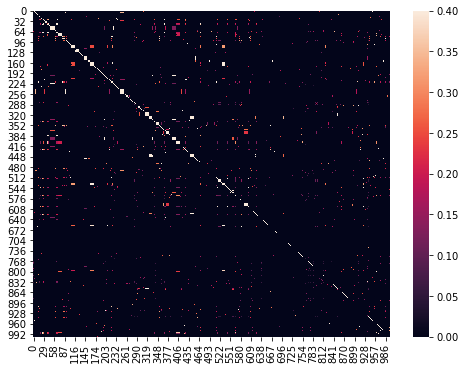

In [36]:
# calculate order based on clustering
order = np.argsort(clusters)

# calculate cosine similarity for each article
cs_o = cosine_similarity(tf.iloc[order])

f, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cs_o, vmax = 0.4)

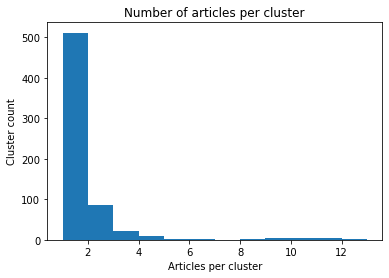

In [37]:
counts = np.zeros(np.max(ac.labels_))
for lbl in range(np.max(ac.labels_)):
    counts[lbl] = np.sum(ac.labels_==lbl)
    
plt.hist(counts, bins=12)
plt.title('Number of articles per cluster')
plt.xlabel('Articles per cluster')
plt.ylabel('Cluster count')
plt.show()


In [38]:
# show the cluster members for the larger clusters
for cluster in np.where(counts>7)[0]:
    for ind in np.where(clusters==cluster)[0]:
        print('%.2d: %s' % (cluster, df.iloc[ind]['Nounss']))

19: ['Vetlesen', 'Glimt', 'seriegull', 'poengs', 'luke']
19: ['Vetlesen', 'Glimt', 'seriegull', 'poengs', 'luke']
19: ['Vetlesen', 'Glimt', 'seriegull']
19: ['Vetlesen', 'Glimt', 'seriegull', 'poengs', 'luke']
19: ['Vetlesen', 'Glimt', 'seriegull', 'poengs', 'luke']
19: ['Vetlesen', 'Glimt', 'seriegull', 'poengs', 'luke']
19: ['Vetlesen', 'Glimt', 'seriegull', 'poengs', 'luke']
19: ['Vetlesen', 'Glimt', 'seriegull', 'poengs', 'luke']
19: ['Vetlesen', 'Glimt', 'seriegull', 'poengs', 'luke']
19: ['Vetlesen', 'Glimt', 'seriegull', 'poengs', 'luke']
19: ['Vetlesen', 'Glimt', 'seriegull', 'poengs', 'luke']
19: ['Vetlesen', 'Glimt', 'seriegull', 'poengs', 'luke']
19: ['Vetlesen', 'Glimt', 'seriegull', 'poengs', 'luke']
23: ['Markussen', 'Vålerenga', 'cupgullet']
23: ['Markussen', 'Vålerenga', 'cupgullet']
23: ['Markussen', 'Vålerenga', 'cupgullet']
23: ['Markussen', 'Vålerenga', 'cupgullet']
23: ['Markussen', 'Vålerenga', 'cupgullet']
23: ['Markussen', 'Vålerenga', 'cupgullet']
23: ['Markuss

In [39]:
import sklearn
sklearn_version = sklearn.__version__
print(sklearn_version)

1.0.2


In [58]:
aggmodel = AgglomerativeClustering(distance_threshold=0,
                                   n_clusters=None,linkage = "ward")  
aggmodel = aggmodel.fit(tf)

aggmodel.n_clusters_




1000

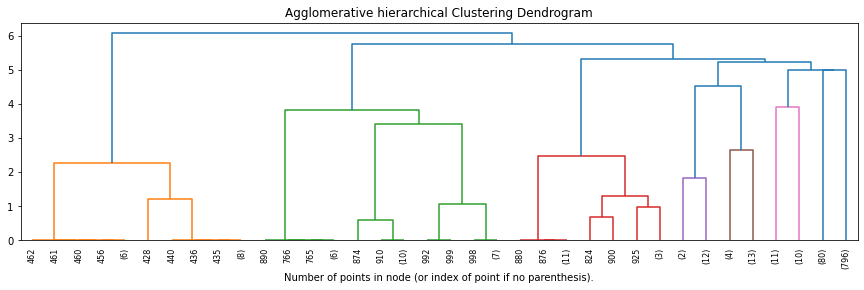

In [60]:
f,ax=plt.subplots(1,figsize=(15,4))
plt.title("Agglomerative hierarchical Clustering Dendrogram")
plot_dendrogram(aggmodel, truncate_mode="level",  p=5, leaf_rotation=90)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()



## principal component anlysis to set n_clusters

In [44]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pcs = pca.fit_transform(tf)

In [47]:
all_pca = PCA()
all_pca.fit(tf)

PCA()

In [48]:
print('%d PCs needed to explain 99%% of the variance' % 
      np.where(np.cumsum(all_pca.explained_variance_ratio_)>0.99)[0][0])

print('%d PCs needed to explain 95%% of the variance' % 
      np.where(np.cumsum(all_pca.explained_variance_ratio_)>0.95)[0][0])

print('%d PCs needed to explain 90%% of the variance' % 
      np.where(np.cumsum(all_pca.explained_variance_ratio_)>0.9)[0][0])

652 PCs needed to explain 99% of the variance
565 PCs needed to explain 95% of the variance
492 PCs needed to explain 90% of the variance


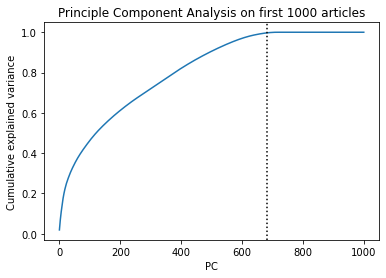

In [49]:
plt.plot(np.cumsum(all_pca.explained_variance_ratio_))
plt.axvline(x=680, c='k', ls=':')
plt.xlabel('PC')
plt.ylabel('Cumulative explained variance')
plt.title('Principle Component Analysis on first 1000 articles')
plt.show()

In [50]:
all_pcs = all_pca.transform(tf)

## Observing results

In [51]:
for ind in np.where(all_pcs[:,0]>0.4)[0]:
    print('%.2f : %s' % (all_pcs[ind,0], df.iloc[ind]['Nounss']))
    
print('%d articles' % len(np.where(all_pcs[:,0]>0.4)[0]))

0.81 : ['togulykke', 'Salisbury', 'England']
0.81 : ['togulykke', 'Salisbury', 'England']
0.81 : ['togulykke', 'Salisbury', 'England']
0.81 : ['togulykke', 'Salisbury', 'England']
0.81 : ['togulykke', 'Salisbury', 'England']
0.81 : ['togulykke', 'Salisbury', 'England']
0.81 : ['togulykke', 'Salisbury', 'England']
0.81 : ['togulykke', 'Salisbury', 'England']
0.43 : ['mannskaper', 'vei', 'togulykke', 'England']
0.81 : ['togulykke', 'Salisbury', 'England']
0.81 : ['togulykke', 'Salisbury', 'England']
0.79 : ['Salisbury', 'England']
0.79 : ['Salisbury', 'England']
0.81 : ['togulykke', 'Salisbury', 'England']
0.79 : ['Salisbury', 'England']
0.79 : ['Salisbury', 'England']
0.79 : ['Salisbury', 'England']
0.79 : ['Salisbury', 'England']
0.79 : ['Salisbury', 'England']
0.79 : ['Salisbury', 'England']
0.79 : ['Salisbury', 'England']
0.79 : ['Salisbury', 'England']
22 articles


In [54]:
# show the cluster members for the larger clusters
for cluster in np.where(counts>7)[0]:
    print('%d' % cluster)
    for ind in np.where(clusters==cluster)[0]:
        print(df.iloc[ind]['Nounss'])

0
['Aborttilgangen', 'Texas-loven', 'Høyesterett']
['vilje', 'klima', 'koronatiltak']
['Bilskadereparatør', 'biloppretter', 'Gol', 'Auto']
['knep', 'knask']
['tenåringsjente', 'Drammen']
['tenåringsjente', 'Drammen']
['endetiden', '-Jesus', 'Kristus', 'Søkelys']
['Sanna', 'valg', 'kjeden', 'sjef', 'Hønefoss']
['Skrivebordsbakgrunn', 'november', 'Himmelkalenderen']
['sjømatterminal', 'Evenes', 'Transport', 'Logistikk']
['smittetilfeller', 'begravelse']
['ruteoptimering', 'effekten', 'førermangel', 'Transport', 'Logistikk']
['Innkjøpssjef', 'Fiat', 'Alfa', 'Romeo', 'Jeep', 'Adecco', 'Select']
['Skanska', 'Norge', 'del', 'klimasamarbeidet', 'Næring', 'klima']
['brannar', 'Drammen']
['brannar', 'Drammen', 'politiet', 'dei', 'påsette']
['Fleire', 'brannar', 'Drammen', 'dei']
['branner', 'Drammen', 'Lier', 'politiet']
['Vålerenga', 'Brann', '1-0', 'seier']
['brannar', 'tid', 'Drammen']
['branner', 'politiet']
['branner', 'Drammen', 'politiet']
['Fleire', 'påsette', 'brannar', 'Drammen']
['br